### Importações

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

Visualizando a base

In [5]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_households,population_per_households,bedrooms_per_rooms
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   longitude                  17564 non-null  float32 
 1   latitude                   17564 non-null  float32 
 2   housing_median_age         17564 non-null  int8    
 3   total_rooms                17564 non-null  int16   
 4   total_bedrooms             17564 non-null  int16   
 5   population                 17564 non-null  int16   
 6   households                 17564 non-null  int16   
 7   median_income              17564 non-null  float32 
 8   median_house_value         17564 non-null  int32   
 9   ocean_proximity            17564 non-null  category
 10  median_income_cat          17564 non-null  int64   
 11  rooms_per_households       17564 non-null  float32 
 12  population_per_households  17564 non-null  float32 
 13  bedrooms_per_rooms         1756

Separandop as colunas por tipo 

In [7]:
coluna_target = ["median_house_value"] # coluna alvo

coluna_one_hot_encoder = ["ocean_proximity"] # coluna categorica sem ordenamento

coluna_ordinal_encoder = ["median_income_cat"] # coluna categorica ordinal

Nesse primeiro momento vamos fazer apenas o preprocessamento das variáveis categoricas e verificar se o modelo bate o Dummy.

Caso não seja melhor que o Dummy, não vale a pena utilizar o modelo.

Criando o preprocessamento

In [8]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder)
    ],
    remainder="passthrough"

)

Definindo X e y, sendo X todas as colunas com exceção da coluna target, e y a própria coluna target median_house_value

In [9]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]



Definindo os regreessores e o target transformer

In [ ]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinerRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegressionTargetTransform":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}


Treinando e visualinado os resultados, utilizando a função treinar_e_validar_modelo_regressao criada anteriormente.

In [11]:
resultados ={
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}


df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002755,0.003134,-0.000081,-77516.042766,-96239.705692,0.00589
1,DummyRegressor,0.001868,0.002927,-0.000146,-75787.787194,-95217.629397,0.004795
2,DummyRegressor,0.001801,0.002869,-0.001737,-76753.598961,-96253.253947,0.00467
3,DummyRegressor,0.001809,0.002931,-0.000101,-76837.804811,-95983.885799,0.00474
4,DummyRegressor,0.001826,0.004688,-0.000114,-76617.245449,-96182.764729,0.006515
5,LinerRegression,0.139679,0.010549,0.682162,-39855.690921,-54254.958115,0.150228
6,LinerRegression,0.012363,0.007104,0.66999,-40272.565406,-54695.230224,0.019466
7,LinerRegression,0.013344,0.007676,0.649247,-42178.059246,-56955.988686,0.02102
8,LinerRegression,0.011557,0.007045,0.669873,-40806.492452,-55146.31876,0.018602
9,LinerRegression,0.011434,0.006463,0.669023,-40788.496555,-55331.351171,0.017897


Nota-se que o LinearRegressionTargetTransform obteve a melhor média

In [12]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002012,0.00331,-0.000436,-76702.495836,-95975.447913,0.005322
LinearRegressionTargetTransform,0.024135,0.008654,0.671185,-38909.258354,-55011.704371,0.032789
LinerRegression,0.037675,0.007767,0.668059,-40780.260916,-55276.769391,0.045443


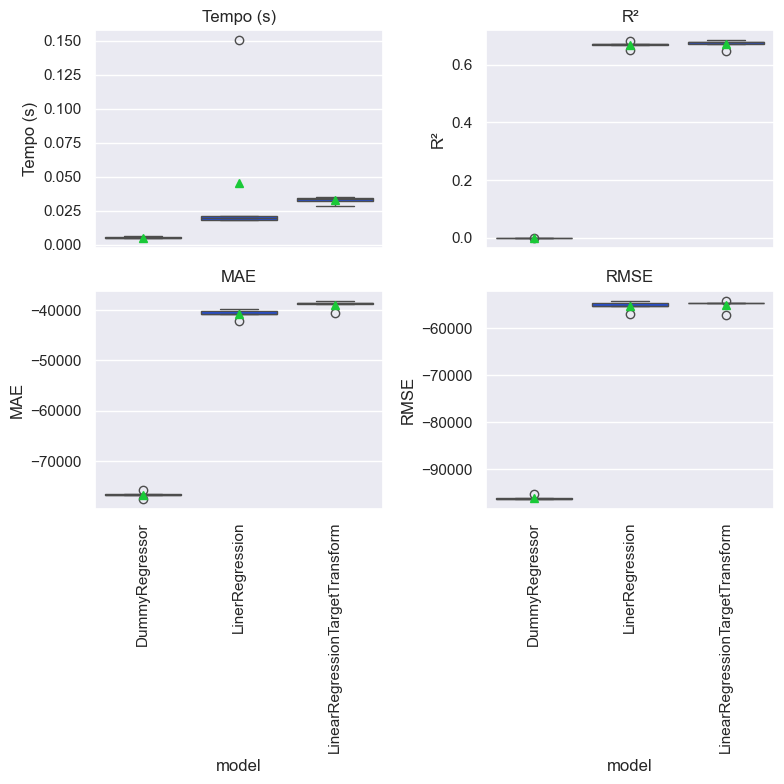

In [13]:
plot_comparar_metricas_modelos(df_resultados)

Nota-se que vale a pena utilizar o modelo Linearregression em comparação ao DummyRegression que é apenas o chute da média.



In [14]:
param_grid = {
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [15]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Nota-se que o melhor paramatro foi o QuantileTransformer

In [17]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

In [18]:
grid_search.best_score_

np.float64(-54424.18489570175)

## Verificando atuação de cada coefiente

In [19]:
coefs= dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
    
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.454980
remainder__longitude,-0.295049
remainder__latitude,-0.288617
remainder__population_per_households,-0.280408
one_hot__ocean_proximity_NEAR BAY,-0.201338
one_hot__ocean_proximity_NEAR OCEAN,-0.059939
remainder__total_bedrooms,-0.000229
remainder__total_rooms,-0.000060
remainder__population,-0.000035
remainder__households,0.000855


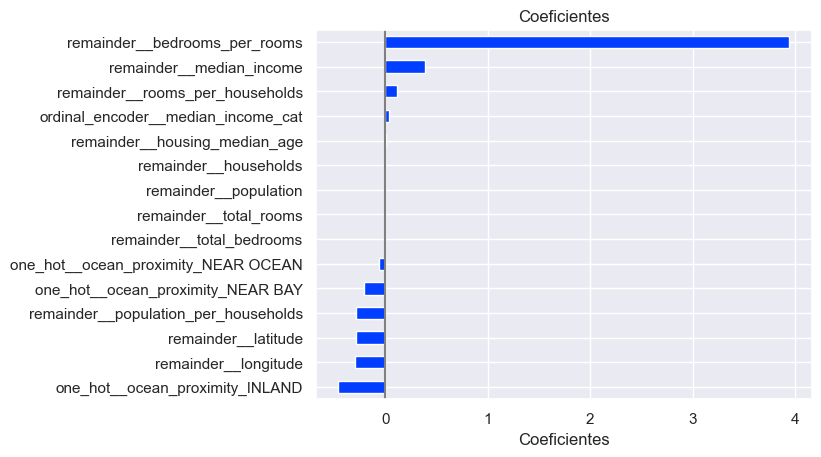

In [20]:
plot_coeficientes(coefs)

Comparando diferentes regressores e preprocessamentos

In [25]:
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinerRegression":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegressionTargetPower":{
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "LinearRegressionTargetQuantile":{
        "preprocessor": grid_search.best_estimator_.regressor_['preprocessor'],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados ={
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}


df_resultados = organiza_resultados(resultados)

df_resultados


,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002555,0.002994,-0.000081,-77516.042766,-96239.705692,0.005549
1,DummyRegressor,0.001797,0.002867,-0.000146,-75787.787194,-95217.629397,0.004664
2,DummyRegressor,0.001776,0.00283,-0.001737,-76753.598961,-96253.253947,0.004606
3,DummyRegressor,0.001767,0.0028,-0.000101,-76837.804811,-95983.885799,0.004567
4,DummyRegressor,0.001772,0.002816,-0.000114,-76617.245449,-96182.764729,0.004589
5,LinerRegression,0.011122,0.006743,0.682162,-39855.690921,-54254.958115,0.017866
6,LinerRegression,0.012615,0.008034,0.66999,-40272.565406,-54695.230224,0.020649
7,LinerRegression,0.012905,0.007601,0.649247,-42178.059246,-56955.988686,0.020506
8,LinerRegression,0.012358,0.00665,0.669873,-40806.492452,-55146.31876,0.019008
9,LinerRegression,0.010965,0.006439,0.669023,-40788.496555,-55331.351171,0.017405


In [26]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001933,0.002861,-0.000436,-76702.495836,-95975.447913,0.004795
LinearRegressionTargetPower,0.020289,0.007592,0.671185,-38909.258354,-55011.704371,0.027881
LinearRegressionTargetQuantile,0.015867,0.00731,0.678211,-38680.417271,-54420.853555,0.023177
LinerRegression,0.011993,0.007094,0.668059,-40780.260916,-55276.769391,0.019087


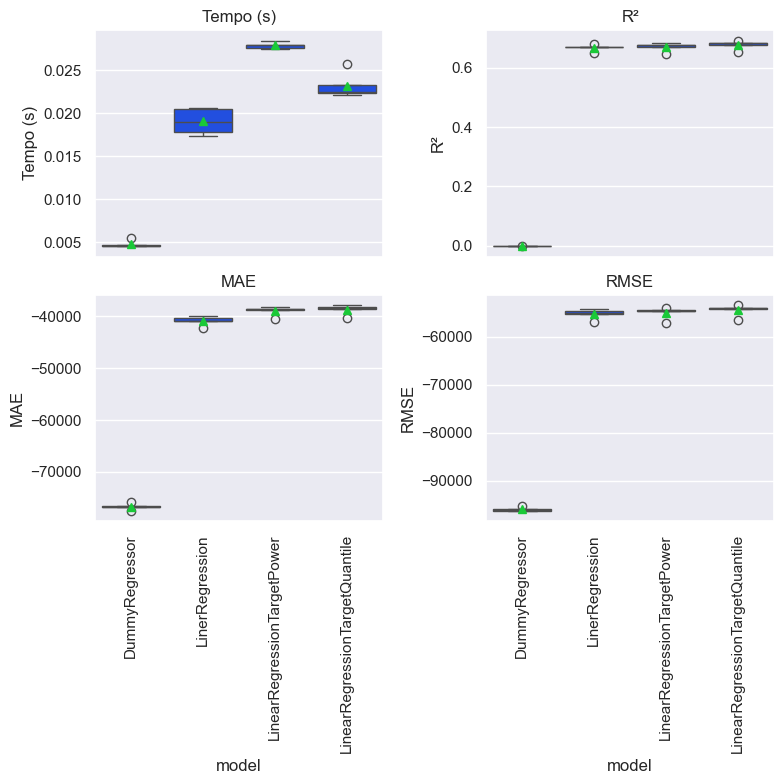

In [27]:
plot_comparar_metricas_modelos(df_resultados)

VErificando distruição e disperção dos dados previstos

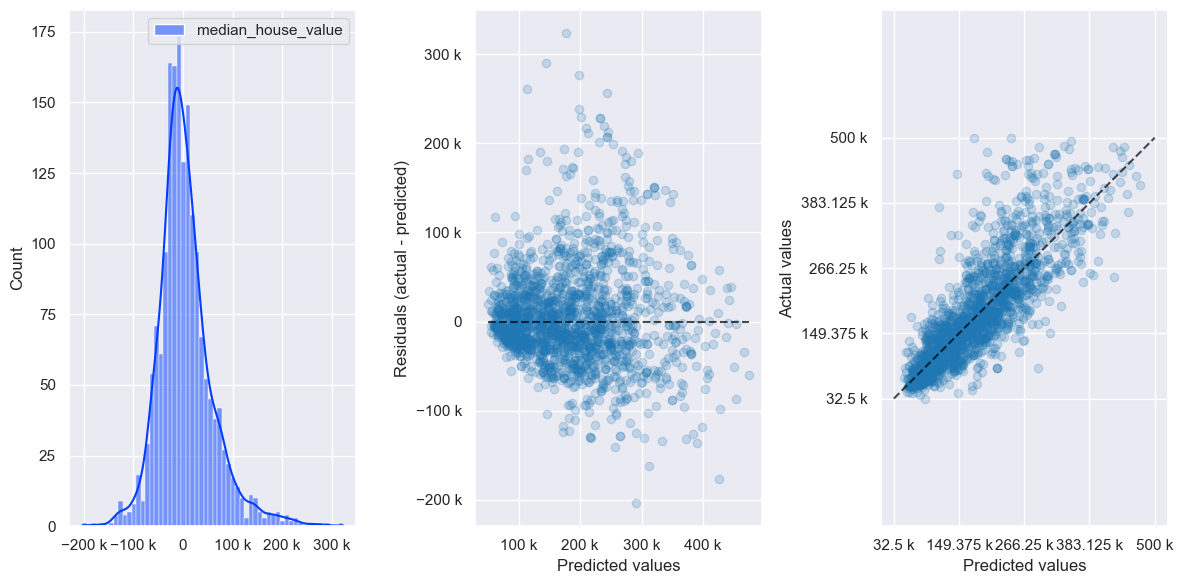

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True, fracao_amostra=0.1)